In [541]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import kstest

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import IsolationForest

import statsmodels.api as sm
import sys

from sklearn.decomposition import PCA
from scipy.stats import bartlett
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity,FactorAnalyzer
from sklearn.preprocessing import StandardScaler

In [3]:
df_original = pd.read_csv('Base mesclada.csv')
print('Quantidade variaveis na base original {}'.format(df_original.columns.shape[0]))
df_original.head()

Quantidade variaveis na base original 82


,Unnamed: 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [4]:
# Verifico quais sao as variaveis metricas e seleciona apenas as metricas
objects = ['object']
df_numerical = df_original.select_dtypes(exclude=objects)
colunas_para_Regressao_Logistica = df_numerical.columns
df_numerical = df_numerical.drop(['Unnamed: 0','Id'], axis=1)

print('Quantidade variaveis metricas {}'.format(df_numerical.columns.shape[0]))

Quantidade variaveis metricas 37


In [5]:
# Verifico se ha colunas com problemas de dados como (nan, etc)
colunas_com_problemas = []
for c in df_numerical.columns:
    if(not np.all(np.isfinite(df_numerical[c]))):
        colunas_com_problemas.append(c)

print("Atributos que precisam de ajuste")
colunas_com_problemas

Atributos que precisam de ajuste


['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

In [6]:
print("Quantidade de exemplos no conjunto antes do filtro:{}".format(df_numerical.shape[0]))
# Retiro os dados com problemas (nan, faltantes, etc)
for c in df_numerical.columns:
    if(not np.all(np.isfinite(df_numerical[c]))):
        df_numerical = df_numerical[df_numerical[c].apply(lambda x:np.all(np.isfinite(x)))]

print("\nQuantidade de exemplos no conjunto apos o filtro:{}".format(df_numerical.shape[0]))

Quantidade de exemplos no conjunto antes do filtro:2919

Quantidade de exemplos no conjunto apos o filtro:2267


In [7]:
df_numerical.corr()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.419825,-0.253163,0.046421,-0.078078,0.048689,0.035080,0.015527,-0.067246,-0.061669,...,-0.022754,-0.010031,-0.027188,-0.029885,-0.050977,-0.007186,-0.041298,-0.002022,-0.019453,-0.090897
LotFrontage,-0.419825,1.000000,0.485548,0.209176,-0.067980,0.112517,0.085974,0.220328,0.224705,0.044234,...,0.119664,0.174613,0.019596,0.029907,0.072001,0.178875,0.047458,0.011824,-0.011665,0.314082
LotArea,-0.253163,0.485548,1.000000,0.145357,-0.061498,0.048100,0.046845,0.137510,0.218642,0.099249,...,0.156902,0.122838,0.017125,0.005380,0.083216,0.129845,0.084831,0.013891,-0.021851,0.322979
OverallQual,0.046421,0.209176,0.145357,1.000000,-0.162223,0.611138,0.582031,0.448197,0.287012,-0.064205,...,0.267974,0.321703,-0.157740,0.001661,0.034092,0.033847,0.021108,0.026866,-0.009583,0.549207
OverallCond,-0.078078,-0.067980,-0.061498,-0.162223,1.000000,-0.434888,-0.005516,-0.168078,-0.081292,0.050810,...,-0.013501,-0.105516,0.086933,0.005670,0.050849,-0.034036,0.016324,-0.007924,0.028438,-0.097516
YearBuilt,0.048689,0.112517,0.048100,0.611138,-0.434888,1.000000,0.633349,0.327697,0.269933,-0.037845,...,0.233748,0.233630,-0.376977,0.016186,-0.055012,0.002800,-0.006608,0.009702,0.002410,0.367258
YearRemodAdd,0.035080,0.085974,0.046845,0.582031,-0.005516,0.633349,1.000000,0.213514,0.144958,-0.055745,...,0.234684,0.274599,-0.226523,0.022359,-0.052151,-0.008369,-0.003626,0.025529,0.039515,0.363870
MasVnrArea,0.015527,0.220328,0.137510,0.448197,-0.168078,0.327697,0.213514,1.000000,0.328116,-0.044167,...,0.184947,0.146073,-0.126555,0.010228,0.063676,0.008931,0.074037,0.006794,-0.023722,0.369238
BsmtFinSF1,-0.067246,0.224705,0.218642,0.287012,-0.081292,0.269933,0.144958,0.328116,1.000000,-0.051209,...,0.223529,0.146064,-0.105237,0.040797,0.087490,0.110039,0.130131,0.008850,0.024476,0.275982
BsmtFinSF2,-0.061669,0.044234,0.099249,-0.064205,0.050810,-0.037845,-0.055745,-0.044167,-0.051209,1.000000,...,0.084136,-0.007793,0.024306,-0.028079,0.054819,0.058480,-0.004918,-0.012285,0.024006,-0.018690


/var/folders/46/d1gyxnd907l7618h776pcl700000gp/T/ipykernel_56627/826770123.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)


Text(0.5, 1.0, 'Matriz de inter correlacao entre variaveis\n')

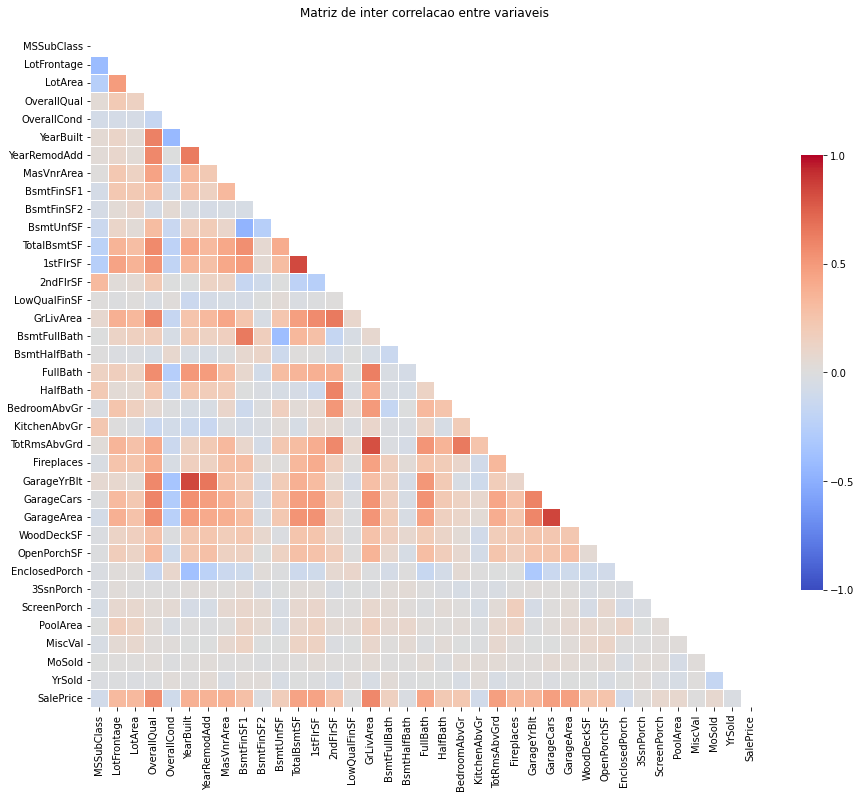

In [10]:
# Organizo um dataframe com os valores p value
linhas = df_numerical.index
colunas = df_numerical.columns

# Matriz de correlação com números
corr_matrix = df_numerical.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
f, ax = plt.subplots(figsize=(15, 20))

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 9})

#add the column names as labels
ax.set_yticklabels(corr_matrix.index)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.title('Matriz de inter correlacao entre variaveis\n')

## Teste de Bartlett para variâncias iguais

Este teste usa as seguintes hipóteses nulas e alternativas:

H0: A variância entre cada grupo é igual.

HA: pelo menos um grupo tem uma variação que não é igual ao resto.

Se o pvalue correspondente da estatística de teste for menor que algum nível de significância (como α = 0,05), então podemos rejeitar a hipótese nula e concluir que nem todos os grupos têm a mesma variância.

fontes:

https://www.statology.org/bartletts-test-python/

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html

In [45]:
calculate_bartlett_sphericity(df_numerical.values)

(198012.8894183724, 0.0)

In [17]:
bartlett(*df_numerical.values)

BartlettResult(statistic=15199.074230134625, pvalue=0.0)

Como pvalue < 0.05 então rejeitamos H0. Então, pelo menos um grupo tem uma variação que não é igual ao resto.

Neste teste de Bartlett, o valor p é 0. O teste foi estatisticamente significativo, indicando que a matriz de correlação observada não é uma matriz de identidade.

## Teste Kaiser-Meyer-Olkin (KMO)

O teste Kaiser-Meyer-Olkin (KMO) mede a adequação dos dados para a análise fatorial. Determina a adequação para cada variável observada e para o modelo completo. KMO estima a proporção da variância entre todas as variáveis observadas. Menor proporção é mais adequado para análise fatorial. Os valores de KMO variam entre 0 e 1. O valor de KMO menor que 0,6 é considerado inadequado.

fonte: https://www.datacamp.com/community/tutorials/introduction-factor-analysis

In [21]:
kmo_all,kmo_model=calculate_kmo(df_numerical)

In [41]:
print('Valor KMO geral {}'.format(kmo_model))

Valor KMO geral 0.787448943057976


Para o exemplo da Escala IDATE: **0.78** -> **BOM**

Vamos verificar se e possivel melhorar este numero

In [92]:
print('Tabela com os valores de KMO para cada variável ordenado decrescemente')
kmo_list = pd.DataFrame(np.column_stack((df_numerical.columns,kmo_all)),columns=['Variavel','KMO']).sort_values(['KMO'],ascending=False,ignore_index=True)
kmo_list

Tabela com os valores de KMO para cada variável ordenado decrescemente


,Variavel,KMO
0,SalePrice,0.969659
1,MasVnrArea,0.957525
2,OverallQual,0.94168
3,OpenPorchSF,0.933371
4,Fireplaces,0.926582
5,WoodDeckSF,0.922609
6,FullBath,0.900709
7,TotRmsAbvGrd,0.898206
8,LotArea,0.894651
9,GarageCars,0.882528


Vemos que ha variaveis com KMO menor que do 0.6. Portanto, vamos elimitar uma a uma ate que todas as variaveis possuam KMO maior fo que 0.6

In [107]:
df_numerical_new = df_numerical.copy()
variavel_pior = kmo_list.loc[kmo_list.shape[0]-1][0]
kmo_pior = kmo_list.loc[kmo_list.shape[0]-1][1]
# Retirar ate que todos os KMO estejam acima de 0.60
while kmo_pior < 0.6:    
    df_numerical_new = df_numerical_new.drop([variavel_pior],axis=1)
    kmo_all_new,kmo_model_new=calculate_kmo(df_numerical_new)

    kmo_list_new = pd.DataFrame(np.column_stack((df_numerical_new.columns,kmo_all_new)),columns=['Variavel','KMO']).sort_values(['KMO'],ascending=False,ignore_index=True)
        
    # Calculo os novos KMO
    variavel_pior = kmo_list_new.loc[kmo_list_new.shape[0]-1][0]
    kmo_pior = kmo_list_new.loc[kmo_list_new.shape[0]-1][1]

In [109]:
print('Valor KMO geral apos as exclusoes: {}'.format(kmo_model_new))

Valor KMO geral apos as exclusoes: 0.8706730087311095


Após excluões, para o exemplo da Escala IDATE: **0.87** -> **ÓTIMO**

Agora podemos seguir com a análise

In [108]:
kmo_list_new

,Variavel,KMO
0,SalePrice,0.969256
1,MasVnrArea,0.955941
2,FullBath,0.944878
3,WoodDeckSF,0.932939
4,OverallQual,0.931979
5,OpenPorchSF,0.917533
6,Fireplaces,0.915329
7,GarageCars,0.880216
8,GarageYrBlt,0.879281
9,GrLivArea,0.87469


## Escolhendo o numero de fatores

In [120]:
# Verificar os Eigenvalues (Autovalores)
fa = FactorAnalyzer(n_factors = 25, rotation=None)
fa.fit(df_numerical_new)
ev, v = fa.get_eigenvalues()

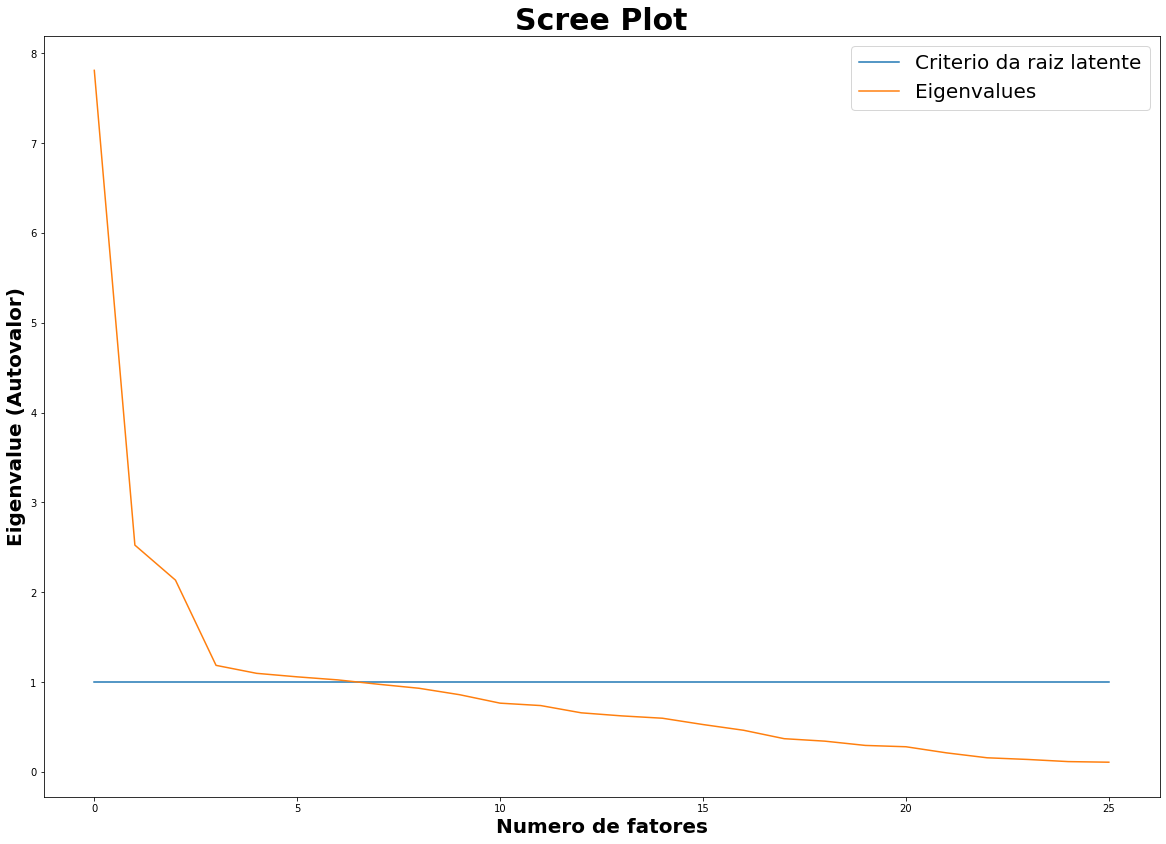

In [164]:
df_scree = pd.concat([pd.DataFrame(np.ones(ev.shape[0]),columns=['Criterio da raiz latente']),pd.DataFrame(ev,columns=['Eigenvalues'])],axis=1)
df_scree.plot(kind='line',figsize=(20,14))
plt.title('Scree Plot', fontdict = {'fontsize':30,'fontweight':'bold'})
plt.ylabel('Eigenvalue (Autovalor)',fontdict = {'fontsize':20,'fontweight':'bold'})
plt.xlabel('Numero de fatores',fontdict = {'fontsize':20,'fontweight':'bold'})
plt.legend(fontsize = 20)

**Podemos notar que apenas os autovalores de 6 fatores são maiores que um. Então, escolhemo apenas 6 fatores de acordo com o criterio da raiz latente.**

## Escolhendo o numero de fatores

### Análise Fatorial

In [351]:
# (a) varimax (orthogonal rotation)
# (b) promax (oblique rotation)
# (c) oblimin (oblique rotation)
# (d) oblimax (orthogonal rotation)
# (e) quartimin (oblique rotation)
# (f) quartimax (orthogonal rotation)
# (g) equamax (orthogonal rotation)
rotacoes = ['varimax',
            'promax',
            'oblimin',
            'oblimax',
            'quartimin',
            'quartimax',
            'equamax']

In [521]:
class analise_fatorial:
    def __init__(self,df_numerical_new, qtd_fatores):
        self.df_numerical_new=df_numerical_new
        self.qtd_fatores=qtd_fatores
        
    def gera_tabela(self,rotacao):
        # Instancio classe FactorAnalyzer
        fa = FactorAnalyzer(n_factors = self.qtd_fatores, rotation=rotacao)

        # Executa a analise para calcular as cargas para os qtd_fatores fatores
        fa.fit(self.df_numerical_new)

        # Gero a tabela de cargas rotacionadas ortogonalmente atraves do varimax
        arr_analise_fatores = fa.loadings_
        
        return arr_analise_fatores

    
    #plotar tabela heatmap das cargas entre varives X fatores
    def plotar_tabela(self,rotacao='varimax'):
        arr_analise_fatores = self.gera_tabela(rotacao)
        # Matriz de correlação com números
        corr_matrix = arr_analise_fatores
        mask = np.zeros_like(corr_matrix, dtype=np.bool)
        # mask[np.triu_indices_from(mask)]= True
        f, ax = plt.subplots(figsize=(15, 20))

        heatmap = sns.heatmap(corr_matrix,
                              mask = mask,
                              square = True,
                              linewidths = .5,
                              cmap = 'coolwarm',
                              cbar_kws = {'shrink': .4,
                                        'ticks' : [-1, -.5, 0, 0.5, 1]},
                              vmin = -1,
                              vmax = 1,
                              annot = True,
                              annot_kws = {'size': 9})

        #add the column names as labels
        sticks_linha = ['Fator ' + str(x) for x in range(arr_analise_fatores.shape[1])]
        ax.set_xticklabels(sticks_linha)
        ax.set_yticklabels(self.df_numerical_new.columns)
        plt.yticks(rotation=0)
        # sns.set_style({'xtick.top': True}, {'ytick.left': True})
        ax.xaxis.set_label_position('top')
        ax.xaxis.set_ticks_position('top')
        plt.title('Matriz de analise de fatores com rotacao {}\n'.format(rotacao))


    #Tabela de fator X quantidade de variaveis (usando o maior valor de carga como criterio)
    def gerar_tabela_fator_qtd_variaveis(self, rotacao='varimax'):
        colunas = ['Fator ' + str(x) for x in range(self.qtd_fatores)]
        linhas = self.df_numerical_new.columns
        
        arr_analise_fatores = self.gera_tabela(rotacao)
        df_carga = pd.DataFrame(arr_analise_fatores,columns=colunas)
        df_carga.index = linhas
        s = df_carga.transpose().idxmax().to_frame().value_counts()
        df_qtd_var_por_fator = pd.DataFrame(s,columns=['Quantidade variaveis por fator']).reset_index()
        df_qtd_var_por_fator.columns=['Fator','Quantidade variaveis por fator']
        df_qtd_var_por_fator = df_qtd_var_por_fator.set_index('Fator')

        return df_qtd_var_por_fator

        
    def gerar_tabela_var_fatores_rotacoes(self):
        fatores_nomes = ['Fator ' + str(x) for x in range(self.qtd_fatores)]

        aux = pd.DataFrame(fatores_nomes,columns=['Fator']).reset_index()
        aux = aux.set_index('Fator')

        rotacoes = ['varimax',
                     'promax',
                     'oblimin',
                     'oblimax',
                     'quartimin',
                     'quartimax',
                     'equamax']
        colunas_rotacoes = ['Quantidade variaveis por fator, rotacao ' + x for x in rotacoes]
        
        for indice, rot in enumerate(rotacoes):
            novo_df_fatores = self.gerar_tabela_fator_qtd_variaveis(rot)
            aux = aux.merge(novo_df_fatores,'left', left_index=True, right_index=True)
        aux = aux.drop(['index'],axis=1)
        aux.columns = colunas_rotacoes
        return aux

    def distribuicao_variavel_por_fator(self,rotacao='varimax'):
        arr_analise_fatores = self.gera_tabela(rotacao)        
        colunas = ['Fator ' + str(x) for x in range(self.qtd_fatores)]
        df_carga = pd.DataFrame(arr_analise_fatores,columns=colunas)       
        df_carga.index = self.df_numerical_new.columns
        df_separacao_variavel_fator = df_carga.transpose().idxmax().to_frame().sort_values([0])
        df_separacao_variavel_fator.columns=['Fator']
        return df_separacao_variavel_fator
    
    # Gerar a variancia de cada fator
    def gerar_variancia_fatores(self, rotacao):        
        # Instancio classe FactorAnalyzer
        fa = FactorAnalyzer(n_factors = self.qtd_fatores, rotation=rotacao)

        # Executa a analise para calcular as cargas para os qtd_fatores fatores
        fa.fit(self.df_numerical_new)
        colunas = ['Fator ' + str(x) for x in range(self.qtd_fatores)]
        df_variancia_cada_fator = pd.DataFrame(fa.get_factor_variance(),columns=colunas)
        df_variancia_cada_fator.index = [
            'SS Loadings',
            'Proportion Var',
            'Cumulative Var'    
        ]
        return df_variancia_cada_fator
    
    def gerar_comunalidades(self,rotacao):
        # Instancio classe FactorAnalyzer
        fa = FactorAnalyzer(n_factors = self.qtd_fatores, rotation=rotacao)

        # Executa a analise para calcular as cargas para os qtd_fatores fatores
        fa.fit(self.df_numerical_new)        
        df_Comunalidades = pd.DataFrame(fa.get_communalities(),columns=['Comunalidades'])
        df_Comunalidades.index = self.df_numerical_new.columns
        df_Comunalidades = df_Comunalidades.sort_values(['Comunalidades'], ascending=False)
        return df_Comunalidades

### Analise com 6 fatores

/var/folders/46/d1gyxnd907l7618h776pcl700000gp/T/ipykernel_56627/2223285279.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)
/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/pandas/core/frame.py:9191: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Quantidade variaveis por fator_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(
/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/pandas/core/frame.py:9191: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Quantidade variaveis por fator_x'} in the result is dep

,"Quantidade variaveis por fator, rotacao varimax","Quantidade variaveis por fator, rotacao promax","Quantidade variaveis por fator, rotacao oblimin","Quantidade variaveis por fator, rotacao oblimax","Quantidade variaveis por fator, rotacao quartimin","Quantidade variaveis por fator, rotacao quartimax","Quantidade variaveis por fator, rotacao equamax"
Fator,,,,,,,
Fator 0,9.0,8,5,18.0,5,10,10
Fator 1,9.0,3,4,3.0,4,6,6
Fator 2,4.0,8,8,4.0,8,6,6
Fator 3,2.0,4,5,1.0,5,2,2
Fator 4,2.0,2,3,NaN,3,1,1
Fator 5,NaN,1,1,NaN,1,1,1


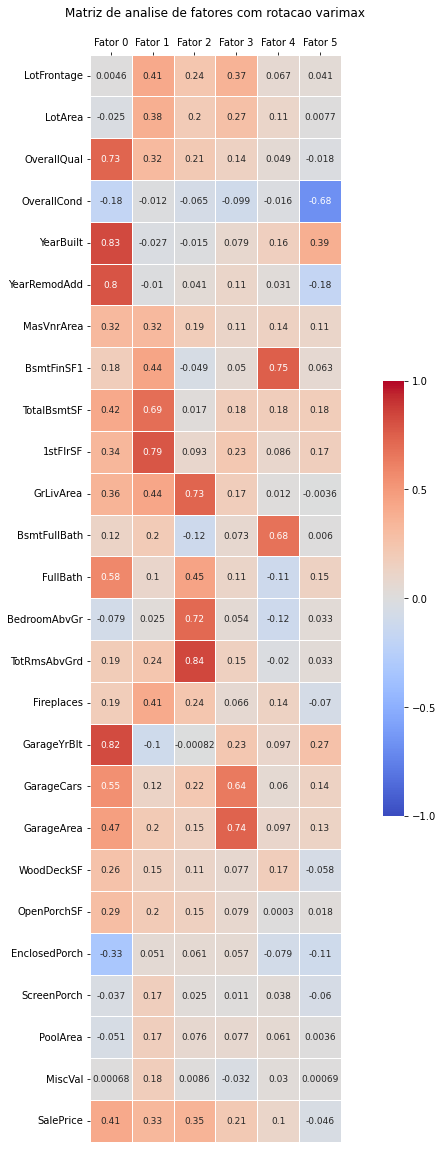

In [489]:
obj = analise_fatorial(df_numerical_new,6)
obj.plotar_tabela()
obj.gerar_tabela_var_fatores_rotacoes()

**Fator 5 ficou com zero variaveis!**

**Rodar novamente a analise com 5 fatores**

/var/folders/46/d1gyxnd907l7618h776pcl700000gp/T/ipykernel_56627/2223285279.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)
/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/pandas/core/frame.py:9191: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Quantidade variaveis por fator_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(
/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/pandas/core/frame.py:9191: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Quantidade variaveis por fator_x'} in the result is dep

,"Quantidade variaveis por fator, rotacao varimax","Quantidade variaveis por fator, rotacao promax","Quantidade variaveis por fator, rotacao oblimin","Quantidade variaveis por fator, rotacao oblimax","Quantidade variaveis por fator, rotacao quartimin","Quantidade variaveis por fator, rotacao quartimax","Quantidade variaveis por fator, rotacao equamax"
Fator,,,,,,,
Fator 0,8.0,7,6,18.0,6,10,10
Fator 1,11.0,4,4,4.0,4,7,7
Fator 2,4.0,9,10,3.0,10,7,7
Fator 3,3.0,5,5,1.0,5,1,1
Fator 4,NaN,1,1,NaN,1,1,1


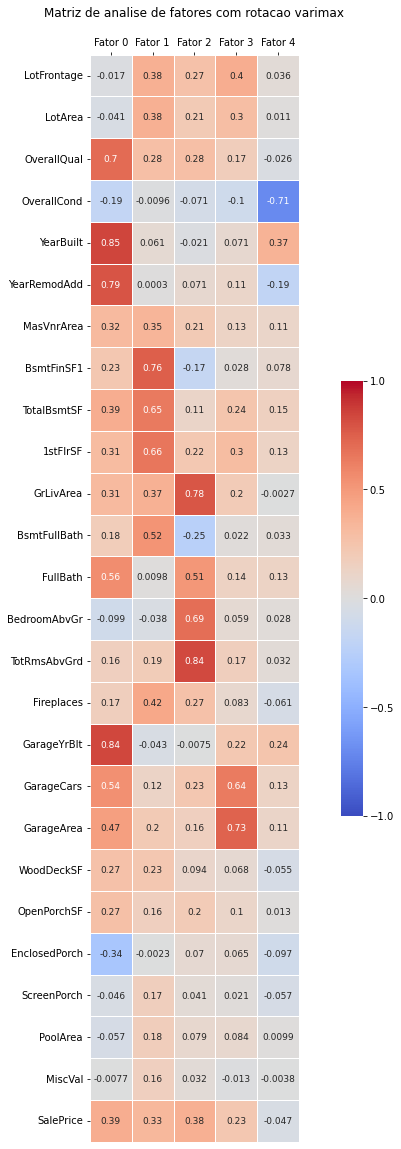

In [490]:
obj = analise_fatorial(df_numerical_new,5)
obj.plotar_tabela()
obj.gerar_tabela_var_fatores_rotacoes()

**Fator 4 ficou com zero variaveis!**

**Rodar novamente a analise com 4 fatores**

/var/folders/46/d1gyxnd907l7618h776pcl700000gp/T/ipykernel_56627/506095197.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)
/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/pandas/core/frame.py:9191: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Quantidade variaveis por fator_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(
/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/pandas/core/frame.py:9191: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Quantidade variaveis por fator_x'} in the result is depr

,"Quantidade variaveis por fator, rotacao varimax","Quantidade variaveis por fator, rotacao promax","Quantidade variaveis por fator, rotacao oblimin","Quantidade variaveis por fator, rotacao oblimax","Quantidade variaveis por fator, rotacao quartimin","Quantidade variaveis por fator, rotacao quartimax","Quantidade variaveis por fator, rotacao equamax"
Fator,,,,,,,
Fator 0,8,5,4,18,4,10,10
Fator 1,5,5,7,3,7,7,7
Fator 2,10,11,10,4,10,8,8
Fator 3,3,5,5,1,5,1,1


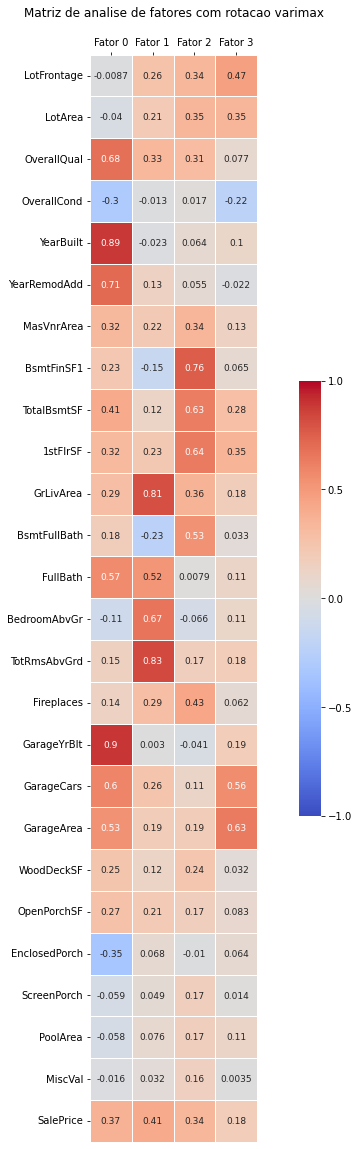

In [522]:
obj = analise_fatorial(df_numerical_new,4)
obj.plotar_tabela()
obj.gerar_tabela_var_fatores_rotacoes()

**Agora parece todos os fatores ficaram com uma variavel**

**Porem, nao ficou muito bem distribuida**

**De qualquer forma, escolheu-se a rotacao promax por ter tido a melhor distribuicao**

In [829]:
df_variavel_fator = obj.distribuicao_variavel_por_fator('promax')
df_variavel_fator

,Fator
OpenPorchSF,Fator 0
OverallQual,Fator 0
GarageYrBlt,Fator 0
YearBuilt,Fator 0
YearRemodAdd,Fator 0
FullBath,Fator 1
TotRmsAbvGrd,Fator 1
BedroomAbvGr,Fator 1
GrLivArea,Fator 1
SalePrice,Fator 1


In [830]:
coluna_fatores = ['Fator ' + str(x) for x in range(4)]
for coluna in coluna_fatores:
    df_variavel_fator[coluna] = (df_variavel_fator['Fator']==coluna).apply(lambda x:int(x))
# df_variavel_fator['Fator 0'] = df_variavel_fator['Fator'].apply(lambda x:[int(('Fator ' + str(y)) == x) for y in range(4)])
# (df_variavel_fator['Fator']=='Fator 0').apply(lambda x:int(x))
# df_variavel_fator = df_variavel_fator.drop(['Fator'],axis=1)
indices_variavel_fator_originais = df_variavel_fator.index
# df_variavel_fator = df_variavel_fator.set_index('Fator')
df_variavel_fator

,Fator,Fator 0,Fator 1,Fator 2,Fator 3
OpenPorchSF,Fator 0,1,0,0,0
OverallQual,Fator 0,1,0,0,0
GarageYrBlt,Fator 0,1,0,0,0
YearBuilt,Fator 0,1,0,0,0
YearRemodAdd,Fator 0,1,0,0,0
FullBath,Fator 1,0,1,0,0
TotRmsAbvGrd,Fator 1,0,1,0,0
BedroomAbvGr,Fator 1,0,1,0,0
GrLivArea,Fator 1,0,1,0,0
SalePrice,Fator 1,0,1,0,0


In [831]:
df_variavel_fator_t = df_variavel_fator.transpose().drop(['Fator'])
df_variavel_fator_t = df_variavel_fator_t.reset_index()

In [855]:
df_variavel_fator.iloc[0][0]

'Fator 0'

(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

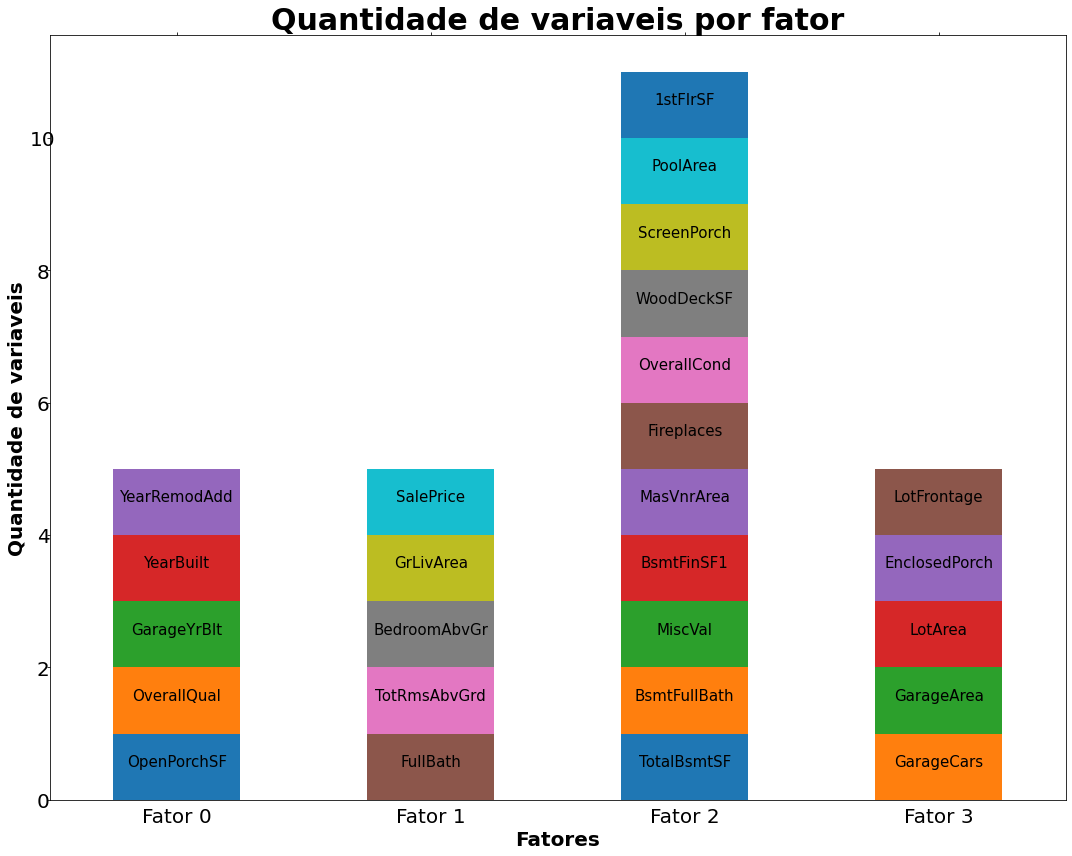

In [867]:
ax = df_variavel_fator_t.plot(kind='bar', stacked=True, legend=None, figsize=(15, 12))
# Iterrating over the bars one-by-one
# for indice, bar in enumerate(ax.patches):
#     indice_original = indice % 4
#     ax.annotate(
#                 indices_variavel_fator_originais[indice_original],
#                (bar.get_x() + bar.get_width() / 2,
#                 bar.get_y() + bar.get_height() /2), 
#                ha='center', va='center',
#                size=15, xytext=(0, 5),
#                textcoords='offset points')
indice_original = 0
for indice, bar in enumerate(ax.patches): 
    
    if (indice % 4 == 0):
        indice_original += 1
    if df_variavel_fator.iloc[indice_original-1][indice % 4 + 1] > 0:
        ax.annotate(
                    indices_variavel_fator_originais[indice_original-1],
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() /2), 
                   ha='center', va='center',
                   size=15, xytext=(0, 5),
                   textcoords='offset points')

plt.title('Quantidade de variaveis por fator', fontdict = {'fontsize':30,'fontweight':'bold'})
plt.ylabel('Quantidade de variaveis',fontdict = {'fontsize':20,'fontweight':'bold'})
plt.xlabel('Fatores',fontdict = {'fontsize':20,'fontweight':'bold'})
ax.set_xticklabels(coluna_fatores)
plt.xticks(rotation=0, horizontalalignment='center', fontsize = 20)
plt.yticks(rotation=0, horizontalalignment='center', fontsize = 20)

In [517]:
obj.gerar_variancia_fatores('promax')

,Fator 0,Fator 1,Fator 2,Fator 3
SS Loadings,4.093435,2.986867,2.548047,1.472892
Proportion Var,0.157440,0.114879,0.098002,0.056650
Cumulative Var,0.157440,0.272319,0.370321,0.426971


Variância cumulativa total de 42% explicada pelos 4 fatores.

In [710]:
df_comunalidades = obj.gerar_comunalidades('promax')
df_comunalidades

,Comunalidades
GarageYrBlt,0.926345
BsmtFinSF1,0.895629
YearBuilt,0.866940
TotRmsAbvGrd,0.789722
BedroomAbvGr,0.701546
GrLivArea,0.700828
GarageArea,0.646467
GarageCars,0.622369
FullBath,0.598071
BsmtFullBath,0.583232


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, 'GarageYrBlt'),
  Text(1, 0, 'BsmtFinSF1'),
  Text(2, 0, 'YearBuilt'),
  Text(3, 0, 'TotRmsAbvGrd'),
  Text(4, 0, 'BedroomAbvGr'),
  Text(5, 0, 'GrLivArea'),
  Text(6, 0, 'GarageArea'),
  Text(7, 0, 'GarageCars'),
  Text(8, 0, 'FullBath'),
  Text(9, 0, 'BsmtFullBath'),
  Text(10, 0, 'YearRemodAdd'),
  Text(11, 0, 'OverallQual'),
  Text(12, 0, 'TotalBsmtSF'),
  Text(13, 0, '1stFlrSF'),
  Text(14, 0, 'LotFrontage'),
  Text(15, 0, 'SalePrice'),
  Text(16, 0, 'LotArea'),
  Text(17, 0, 'Fireplaces'),
  Text(18, 0, 'EnclosedPorch'),
  Text(19, 0, 'OverallCond'),
  Text(20, 0, 'MasVnrArea'),
  Text(21, 0, 'WoodDeckSF'),
  Text(22, 0, 'OpenPorchSF'),
  Text(23, 0, 'PoolArea'),
  Text(24, 0, 'ScreenPorch'),
  Text(25, 0, 'MiscVal')])

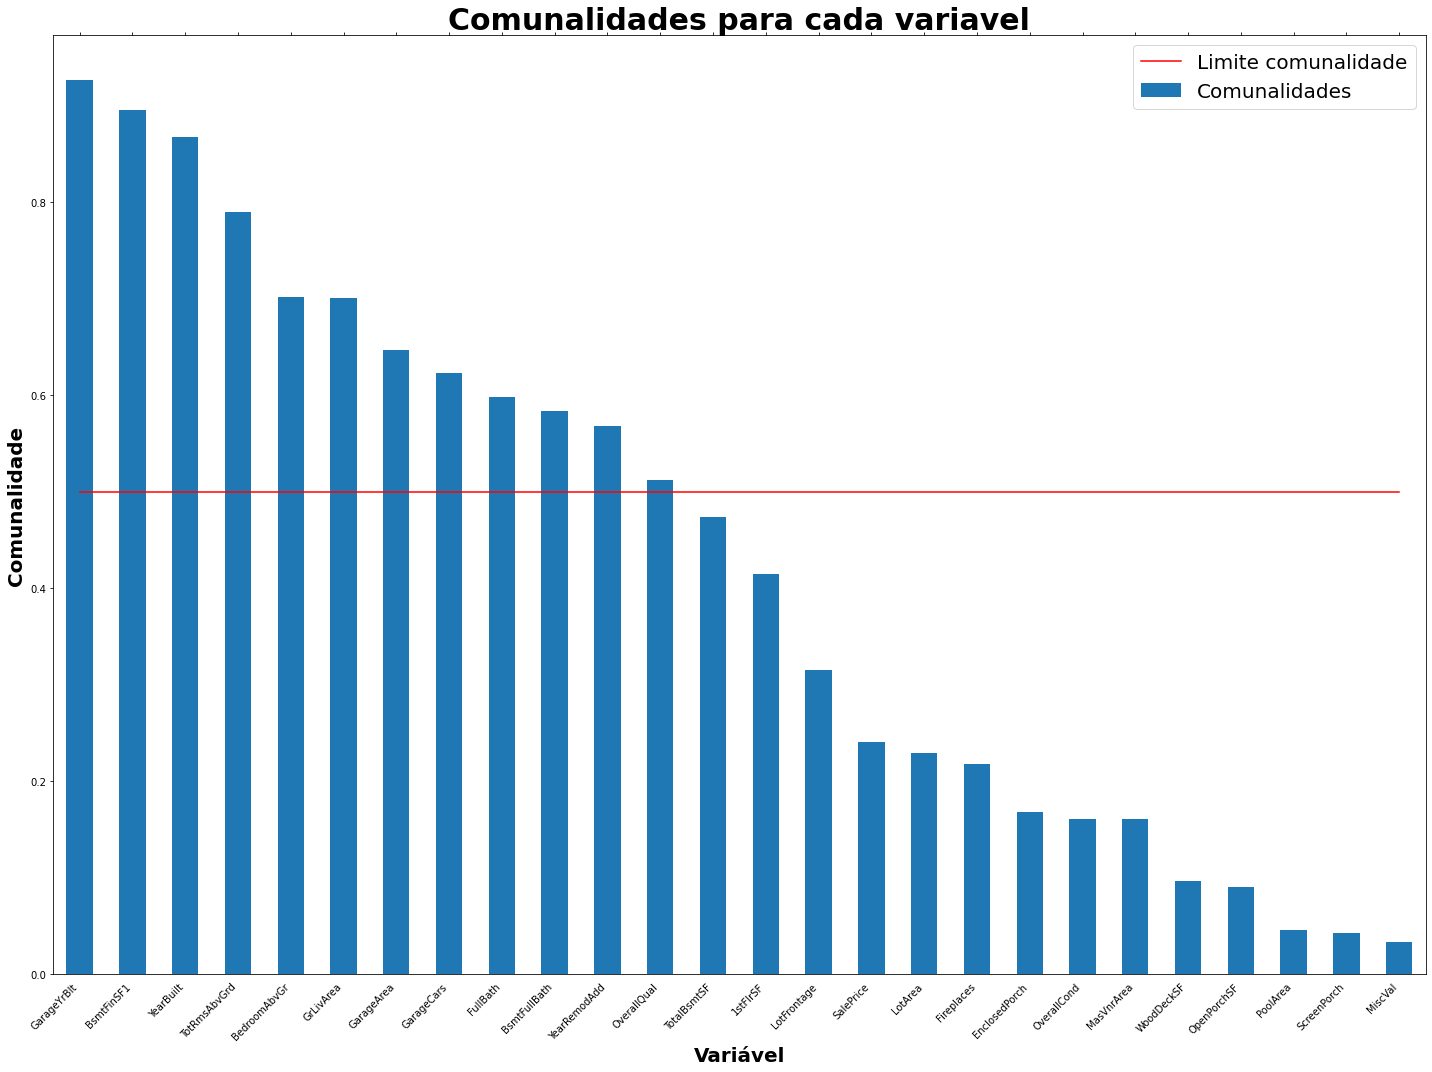

In [723]:
df_comunalidades['Limite comunalidade'] = 0.5
ax = df_comunalidades['Comunalidades'].plot(kind='bar')
df_comunalidades['Limite comunalidade'].plot(kind='line',ax=ax,color = 'red')
plt.title('Comunalidades para cada variavel', fontdict = {'fontsize':30,'fontweight':'bold'})
plt.ylabel('Comunalidade',fontdict = {'fontsize':20,'fontweight':'bold'})
plt.xlabel('Variável',fontdict = {'fontsize':20,'fontweight':'bold'})
plt.legend(fontsize = 20)
plt.xticks(rotation=45, horizontalalignment='right')

# TODO 1: O QUE FAZER AGORA? EXCLUO VARIAVEIS COM COMUNALIDADES BAIXAS (PELO LIVRO, ABAIXO DE 0,5 PODERIA AVALIAR A EXCLUSAO)?

# TODO 2: APLICAR PCA COM 4 COMPONENTES

# Aplicando PCA

Normalizar os dados pois o PCA e influenciado pela escala dos dados

In [528]:
x = df_numerical_new.copy()
x = StandardScaler().fit_transform(x) # normalizing the features
x

array([[-0.20714411, -0.2127163 ,  0.58062759, ..., -0.06886825,
        -0.08420153,  0.44897197],
       [ 0.43560938, -0.03653398, -0.12326693, ..., -0.06886825,
        -0.08420153, -0.00488682],
       [-0.07859341,  0.21624934,  0.58062759, ..., -0.06886825,
        -0.08420153,  0.70111574],
       ...,
       [-2.09255438, -1.21710868, -1.53105595, ..., -0.06886825,
        -0.08420153, -0.28579552],
       [ 3.86362804,  1.55676694, -0.82716144, ..., -0.06886825,
        -0.08420153,  0.62921145],
       [ 0.17850799, -0.03239753,  0.58062759, ..., -0.06886825,
        -0.08420153,  0.10003637]])

In [536]:
pca_house = PCA(n_components=4)
pca_house = pca_house.fit_transform(x)
colunas = ['Fator ' + str(x) for x in range(4)]
df_pca = pd.DataFrame(pca_house,columns=colunas)
df_pca.head()

,Fator 0,Fator 1,Fator 2,Fator 3
0,1.360619,-1.218968,-0.791637,0.124120
1,0.135936,0.370806,0.541970,-1.364092
2,1.488727,-1.052826,-0.344990,0.091854
3,-0.519787,1.308102,-0.126933,1.549651
4,4.291750,0.439397,-0.934110,0.053558


In [535]:
df_numerical_new.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,65.0,8450,7,5,2003,2003,196.0,706.0,856.0,856,...,2003.0,2.0,548.0,0,61,0,0,0,0,208500.0
1,80.0,9600,6,8,1976,1976,0.0,978.0,1262.0,1262,...,1976.0,2.0,460.0,298,0,0,0,0,0,181500.0
2,68.0,11250,7,5,2001,2002,162.0,486.0,920.0,920,...,2001.0,2.0,608.0,0,42,0,0,0,0,223500.0
3,60.0,9550,7,5,1915,1970,0.0,216.0,756.0,961,...,1998.0,3.0,642.0,0,35,272,0,0,0,140000.0
4,84.0,14260,8,5,2000,2000,350.0,655.0,1145.0,1145,...,2000.0,3.0,836.0,192,84,0,0,0,0,250000.0


/var/folders/46/d1gyxnd907l7618h776pcl700000gp/T/ipykernel_56627/4260543786.py:27: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


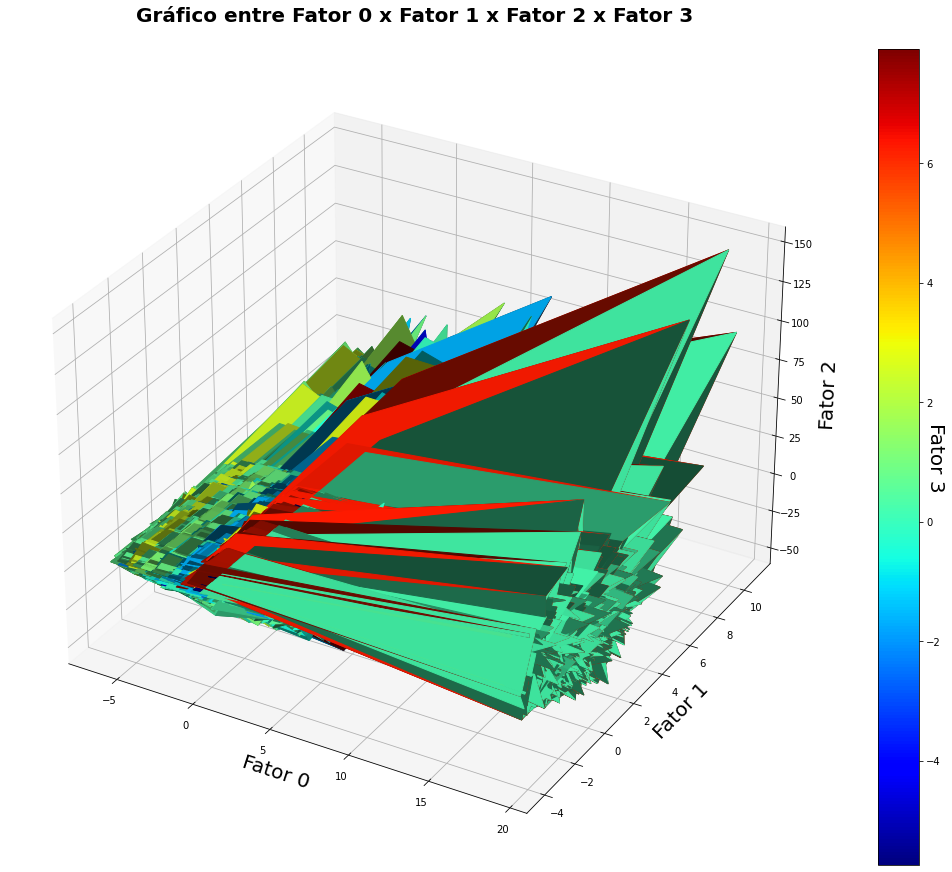

In [695]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# domains
x = df_pca['Fator 0'].values
y = df_pca['Fator 1'].values
z = df_pca['Fator 2'].values
w = df_pca['Fator 3'].values
# convert to 2d matrices
Z = np.outer(z.T, z)
X, Y = np.meshgrid(x, y)
W, _ = np.meshgrid(w, y)

# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = W # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot
fig = plt.figure(figsize=(20,15))
ax = fig.gca(projection='3d')
img = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=True)

plt.title('Gráfico entre Fator 0 x Fator 1 x Fator 2 x Fator 3\n', fontdict = {'fontsize':20, 'fontweight':'bold'})
ax.set_xlabel('Fator 0',fontsize=20)
ax.set_ylabel('Fator 1', fontsize=20)
ax.set_zlabel('\nFator 2',fontsize=20)
barra = fig.colorbar(m)
barra.set_label('Fator 3', rotation=270, fontsize=20)
plt.show()

In [707]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(df_pca, x='Fator 0', y='Fator 1', z='Fator 2',
              color='Fator 3', title='<b>Gráfico entre Fator 0 x Fator 1 x Fator 2 x Fator 3</b>')
fig.update_layout(
    font_family="Courier New",
    font_color="blue",
    title_font_family="Times New Roman",
    title_font_color="black",
    legend_title_font_color="green",
    title_x=0.5
)
fig.show()